The following is the notebook of code written by H. Passmore to create Word Cloud graphics using high and low rated review text for Capstone 1: Amazon Book Reviews & Ratings Predictor. 

# Word Cloud Generator for Amazon Reviews
_Amazon Book Reviews & Ratings Predictor: Word Cloud Graphics_

_Word Cloud Graphics Code_
***

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Build figures inline
%matplotlib inline

In [2]:
# Setup Pandas  
pd.set_option('display.width', 350)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [3]:
# Implement tools to Reduce Document Dimensions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string

In [4]:
# set 'SW' as english stopwords and count them
SW = set(stopwords.words('english'))
print(len(SW))

179


In [5]:
# remove 'not' from set SW
SW.remove('not')

print('Reduced stopword list', SW)
print('Reduced number of stopwords', len(SW))

Reduced stopword list {'how', 'shouldn', 'such', "hadn't", 'weren', 'this', 'then', 'your', 'isn', 's', 'they', 'where', 'of', 'above', 'wouldn', 'am', 'once', 'been', 'in', 'why', 'had', 'those', 'herself', 'needn', 'its', 'an', 'hers', 'with', 'what', 'only', 'did', 'whom', 'does', 'if', 'on', 're', 'it', 'through', 'can', 'ain', 'or', 'now', "mustn't", "it's", "needn't", 'than', 'won', 'same', "weren't", "wouldn't", 'aren', "you'll", 'has', 'she', 'until', 'during', 'about', 'have', "mightn't", 'having', 'both', 'to', 'here', 'after', 'hadn', 'mustn', 'most', "don't", "you're", 'just', 'again', 'very', "isn't", 'for', "wasn't", 'couldn', 'o', 'should', 'him', 'y', 'were', 'before', 'was', 'd', 'being', 'm', 'haven', 'her', "couldn't", 'he', "won't", "should've", 'against', 'some', 'that', 'each', 'other', 'll', 'because', 'below', 'out', 'our', 'any', 'up', 'we', "that'll", 'nor', 'don', 'from', 'between', 'by', 'will', 'over', 'all', 'is', 'at', 'yourself', 'doesn', 'more', "doesn'

In [6]:
# bring the book_revs dataframe into workspace from the inferential statistics code
# load the pickled  DataFrame of Science Textbook Reviews from hard drive in 'rb' mode
import pickle
with open('book_revs_forML.pickle','rb') as f:
    book_revs = pickle.load(f)

In [7]:
# keep only what we need
rev_rate = book_revs.drop(['asin', 'overall', 'summary', 'five_not5', 'token_count', 'caps_count', 'pct_caps'], axis=1)
rev_rate.head(2)

,reviewText,rating_cat
0,This is a good book for the science nerd and t...,0
1,"If you're a biology/genetics enthusiast, this ...",1


## Preprocess review text to reduce document dimensions

In [8]:
# combine my review-specific stopwords with english stopwords as a set
user_defined_stop_words = ['book', 'books']

i = SW
j = list(string.punctuation) + user_defined_stop_words

stopwords = set(i).union(j)

In [9]:
# define first preprocessor
def preprocess(x):
    letters_only = re.sub('[^a-zA-Z]', ' ', str(x))                  # keep alpha only
    words = letters_only.lower().split()                            # lowercase everything  
    useful_words = [w for w in words if w not in set(stopwords)]    # remove stopwords
    return (' '.join(useful_words))

In [10]:
# apply preprocessor to review text
rev_rate['clean_revs'] = rev_rate['reviewText'].apply(preprocess)
rev_rate.tail()

,reviewText,rating_cat,clean_revs
11541,Definitely a MUST-READ if you are a home cooki...,1,definitely must read home cooking enthusiast w...
11542,Pros: Scientifically informative and solid. Kn...,0,pros scientifically informative solid knowing ...
11543,Real fun to read. For everybody that is inters...,0,real fun read everybody intersted cooking cert...
11544,This book will teach you the chemical secrets ...,0,teach chemical secrets techniques usually used...
11545,I paid more than $30 to buy such a superficial...,0,paid buy superficial trivial made big mistake ...


In [12]:
# instantiate the stemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [13]:
# define second preprocessor for tokenization and stemming
def preprocess2(text):
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    tokens = word_tokenize(text)
    stems = [stemmer.stem(t) for t in tokens]
    return stems

In [14]:
# apply second preprocessor to clean_revs
rev_rate['clean_revs'] = rev_rate['clean_revs'].apply(preprocess2)
rev_rate.tail()

,reviewText,rating_cat,clean_revs
11541,Definitely a MUST-READ if you are a home cooki...,1,"[definit, must, read, home, cook, enthusiast, ..."
11542,Pros: Scientifically informative and solid. Kn...,0,"[pros, scientif, inform, solid, know, chemic, ..."
11543,Real fun to read. For everybody that is inters...,0,"[real, fun, read, everybodi, interst, cook, ce..."
11544,This book will teach you the chemical secrets ...,0,"[teach, chemic, secret, techniqu, usual, use, ..."
11545,I paid more than $30 to buy such a superficial...,0,"[paid, buy, superfici, trivial, made, big, mis..."


In [18]:
# clean_revs must be a list of strings for vectorization steps
rev_rate['clean_revs'] = rev_rate['clean_revs'].apply(str)
rev_rate.tail()

,reviewText,rating_cat,clean_revs
11541,Definitely a MUST-READ if you are a home cooki...,1,"['definit', 'must', 'read', 'home', 'cook', 'e..."
11542,Pros: Scientifically informative and solid. Kn...,0,"['pros', 'scientif', 'inform', 'solid', 'know'..."
11543,Real fun to read. For everybody that is inters...,0,"['real', 'fun', 'read', 'everybodi', 'interst'..."
11544,This book will teach you the chemical secrets ...,0,"['teach', 'chemic', 'secret', 'techniqu', 'usu..."
11545,I paid more than $30 to buy such a superficial...,0,"['paid', 'buy', 'superfici', 'trivial', 'made'..."


## Build rating category word clouds

In [15]:
# import WordCloud
from wordcloud import WordCloud

In [19]:
# separate high and low rating words
low_words = ''
high_words = ''
low = rev_rate[rev_rate.rating_cat == 0]
high = rev_rate[rev_rate.rating_cat == 1]

In [20]:
for val in low.clean_revs:
    tokens = word_tokenize(val)
    for words in tokens:
        low_words = low_words + words + ''

In [25]:
for val in high.clean_revs:
    tokens = word_tokenize(val)
    for words in tokens:
        high_words = high_words + words + ''

In [23]:
# Generate a word cloud image
low_wordcloud = WordCloud(max_words=1000, width=600, height=400).generate(low_words)

In [26]:
high_wordcloud = WordCloud(max_words=1000, width=600, height=400).generate(high_words)

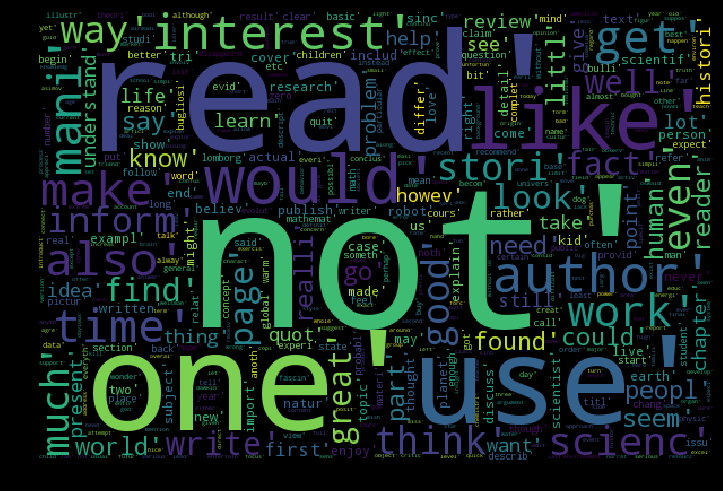

In [24]:
# Low rating Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(low_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

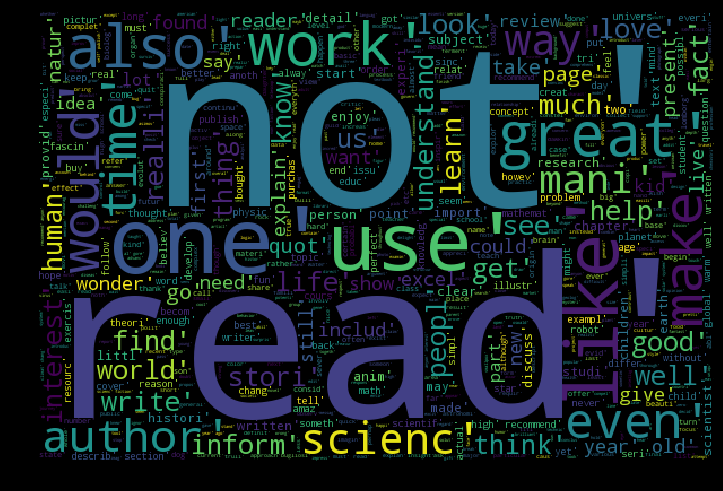

In [27]:
# High rating Word cloud
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(high_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()